## load data 
--- 
data is labeled like this before processing i need to understand the park transform : 
- u_q : Voltage q-component measurement in dq-coordinates (in V)
- coolant : Coolant temperature (in °C)
- stator_winding : Stator winding temperature (in °C) measured with thermocouples
- u_d : Voltage d-component measurement in dq-coordinates
- stator_tooth : Stator tooth temperature (in °C) measured with thermocouples
- motor_speed :Motor speed (in rpm)
- i_d : Current d-component measurement in dq-coordinates
- i_q : Current q-component measurement in dq-coordinates
- pm : Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.
- stator_yoke :Stator yoke temperature (in °C) measured with thermocouples

In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.utils import plot_model

In [9]:
df = pd.read_csv("PMSM.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, :1].values  
target_features = ['pm'] # the most important ones
print(isinstance(X, np.ndarray)) # already a numpy array
print(isinstance(y, np.ndarray)) # already a numpy array
print(df.head())
X.shape # (998070, 11) 
y.shape # (998070, 1) 

True
True
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17  


(1330816, 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [11]:
df['pm'].describe()

count    1.330816e+06
mean     5.850678e+01
std      1.900150e+01
min      2.085696e+01
25%      4.315158e+01
50%      6.026629e+01
75%      7.200837e+01
max      1.136066e+02
Name: pm, dtype: float64

## visualizing the profiles we have 

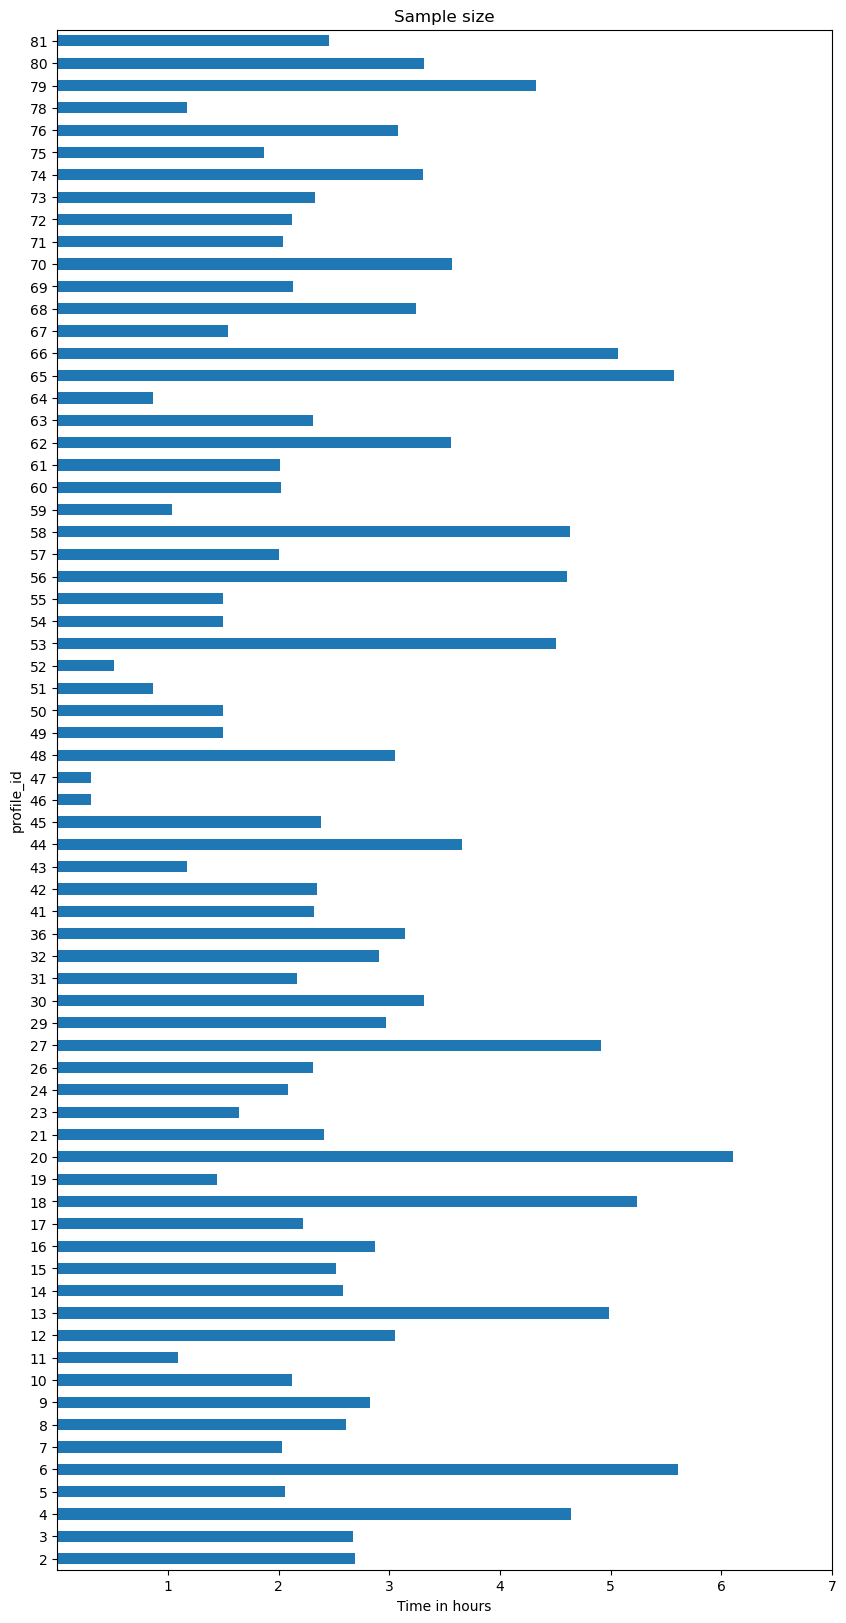

In [12]:
''' p_counts = profile_id.value_counts() 
plt.bar(p_counts.index, p_counts.values)
plt.show() ''' # The histogram is not enough for that we use another methode were we make it vertical
p_counts = df.groupby('profile_id').agg('count').iloc[:, 0] # groupby profile_id and count the number of rows
ax = p_counts.plot.barh(figsize=(10,20) ,title='Sample size') # horizontal bar plot barh
_  = ax.set_xticks(2*3600*np.arange(1, 8)) # we convert hz to hours
_  = ax.set_xticklabels(list(range(1, 8))) # we putted the max value of the x axis to 8
_  = ax.set_xlabel('Time in hours') # we used _ to avoid creating unecessary variables 

### from this plot we can see what profile id we can drop 
---
The plots below show that all measurement sessions range from 20 minutes to around 6 hours. The two short session ids "46" and "47" might be not very representative as temperatures inside electric motors need time to vary.

## Linear correlation
--- 
meaning that taller people tend to weigh more if correlation is positive. 

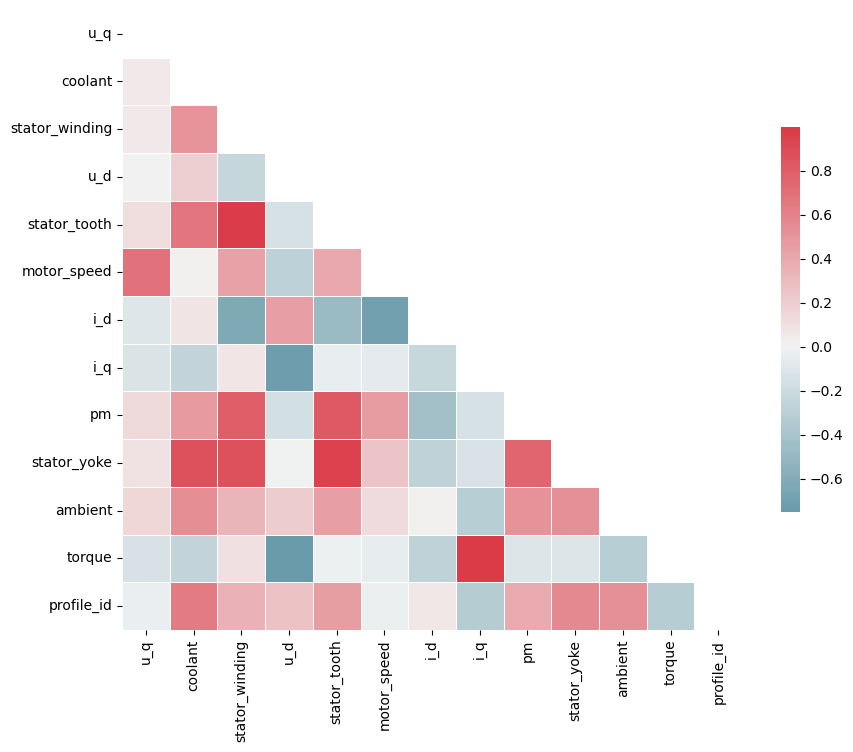

In [13]:
# copilot i want to visualize the linear correlation between my feautures 
corr = df.corr() 
'whats down is usefull but its for visualsation without it its a mess'
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)  # an array of 0 which are false the same size as the mask
mask[np.triu_indices_from(mask)] = True # we want to keep the lower triangle so we put true in the upper triangle
# Generate a custom diverging colormap 
cmap = sns.diverging_palette(220, 10, as_cmap=True) # beautiful colors 
' color stuff '
plt.figure(figsize=(10,10))
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


We observe a very high positve linear correlation between i_q and torque. Moreover, u_d is highly negative linearly correlated with torque and i_q. Indeed, for the former insight we can refer to electric drive theory, where either higher torque is exclusively dependent on i_q in case of similar sized inductances in d- and q-axis, or increasing with higher i_q and slightly decreasing i_d elsewise (more common in practice).

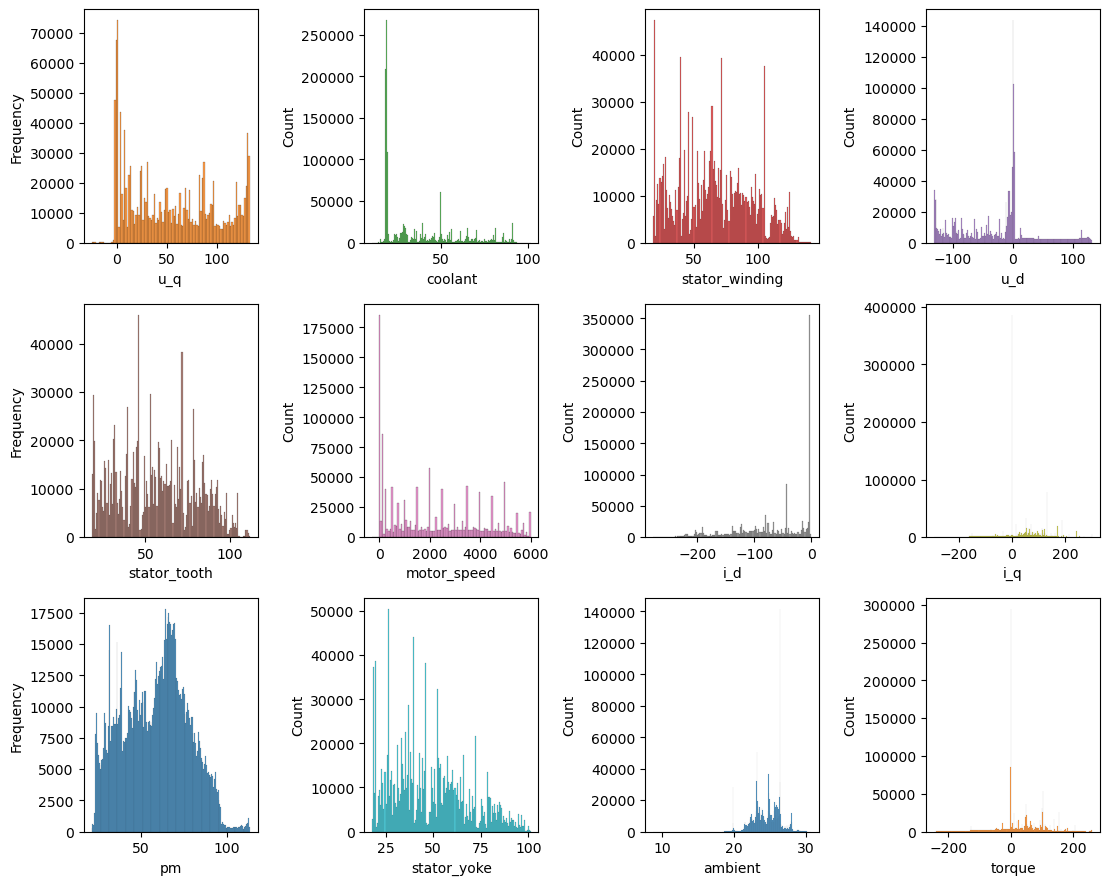

In [14]:
dfui = df.drop(['profile_id'], axis=1)  # dataframe under investigation profile id is uselss

# colors
color_list = plt.cm.tab10(np.linspace(0, 1, 10)[list(range(10))+[0, 1]])
coi = target_features + [c for c in dfui if c not in target_features]  # columns of interest
feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(coi)} if color_list is not None else {}


n_cols = 4
n_rows = np.ceil(dfui.shape[1] / n_cols).astype(int) # 3 this just calculates how many rows we can have after chosing the col number
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3)) # just some settings for ploting 
for i, (ax, col) in enumerate(zip(axes.flatten(), list(dfui.columns))):
    sns.histplot(dfui[col], color=feat_clrs[col], ax=ax)
    if i % n_cols == 0:
        ax.set_ylabel('Frequency')
plt.tight_layout()


## Notes : 
---
- we see that distrubutions aren't gaussian 
- we see some spikes in the distrubutions because values are taken in rest phase 
- we see that temperatures we need are not that spikey indicating a big time constant  

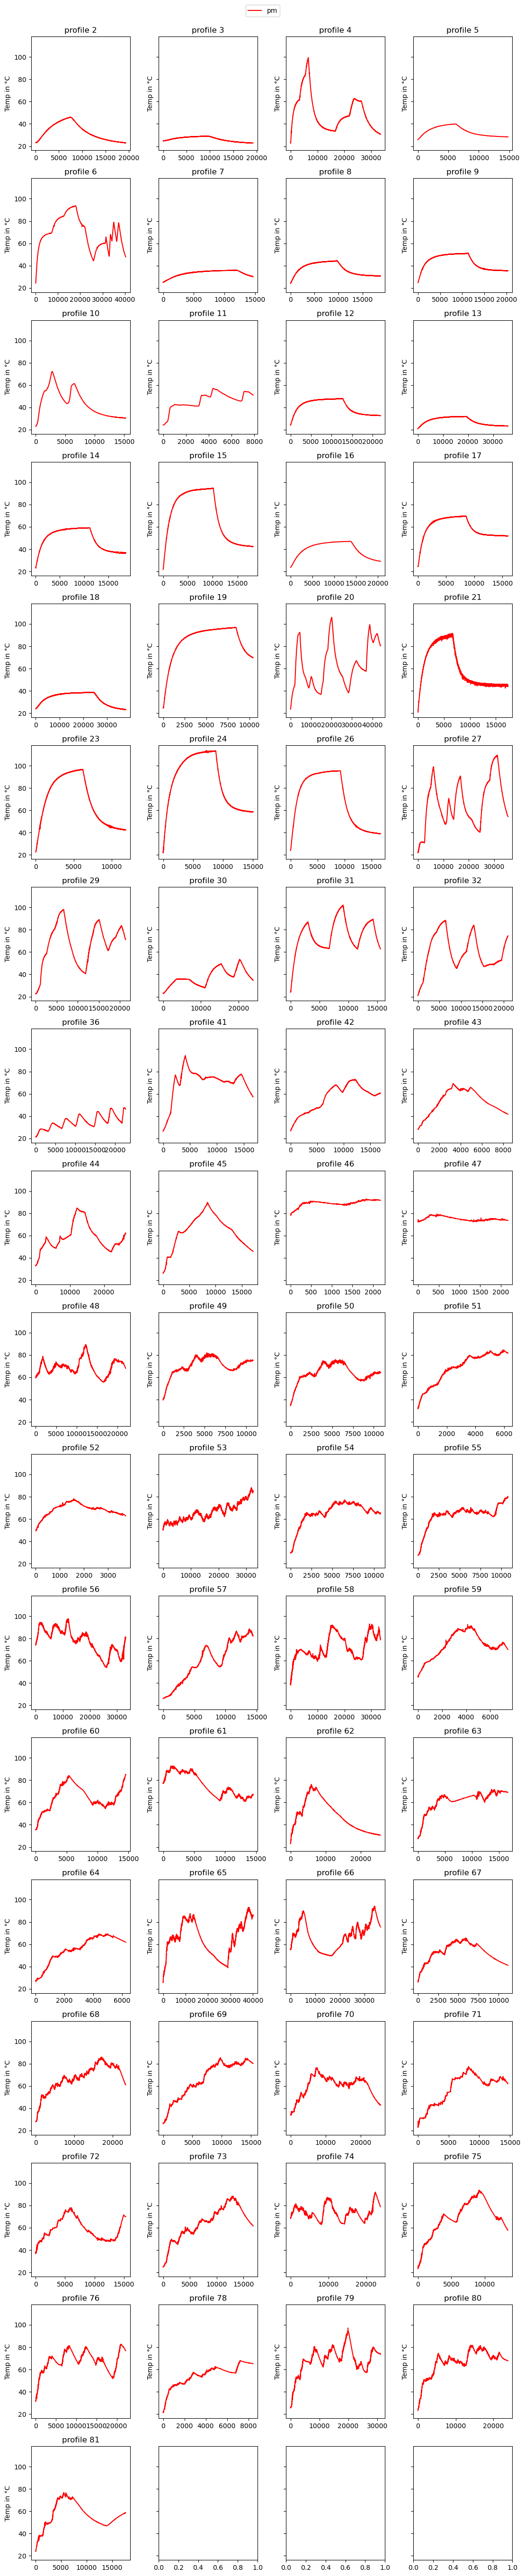

In [16]:
grpd = {pid: df_ for pid, df_ in df.groupby('profile_id')} # we grouped our data in a dict by the group ID so we can see tendancies 
coi = target_features # the 4 temp we are using the PM and the stator tooth and stator yoke and stator winding  
n_cols = 4
n_rows = np.ceil(len(grpd) / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))
for i, (ax, (p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
    for c in coi:
        lines = ax.plot(df_[c].reset_index(drop=True), label=c, color='r')
    ax.set_title(f'profile {p_id}')
    ax.set_ylabel('Temp in °C')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

### We take look at the input features   

### Notes we can take : 
--- 
- While motor excitations (motor_speed, torque, coolant) are sometimes of high dynamic, sometimes of stepwise nature, target temperatures always exhibit low-pass behavior with exponential rise and falls,

- Coolant temperature suffers from measurement artefacts expressed by sharp drops in temperature, which recover as fast,
- PM (Permanent Magnet -> Rotor) temperature expresses the slowest time constant and follows stator temperatures
- Motor_speed and torque (the excitation features) follow sometimes step-wise cycles, sometimes random walks
Some profiles denote resting phases, where all input features stay constant most of the time

## TRAINING


In [17]:

DataSet = pd.read_csv('PMSM.csv')

## spliting data 
We then break the data into features and target variables, split into testing and training and scale the data


In [23]:
X = DataSet[DataSet['profile_id'] != 27].drop(columns = ['pm','profile_id'])
y = DataSet['pm'][DataSet['profile_id'] != 27]

'''it selects all the rows where the profile_id is not equal to 20. 
The resulting dataset, stored in X, will contain all the rows except those where the profile_id is 20.
Similarly, the corresponding values of the 'pm' column for the selected rows are stored in y.'''

X_test = DataSet[DataSet['profile_id'] == 27].drop(columns = ['pm','profile_id'])
y_test = DataSet['pm'][DataSet['profile_id'] == 27]

scaler1 = StandardScaler()
scaler2 = StandardScaler()
X = scaler1.fit_transform(X)
y = scaler2.fit_transform(np.asarray(y).reshape(-1, 1))

X_test = scaler1.transform(X_test)
y_test = scaler2.transform(np.asarray(y_test).reshape(-1, 1))

X_train, X_rnn, y_train, y_rnn = train_test_split(X,y, test_size = 0.5,shuffle=False)

11

In [22]:
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.layers import Concatenate


input_1 = Input(shape=(X.shape[1]))
hlay1_1 = Dense(16,activation = 'relu')(input_1)
hlay2_1 = Dense(16,activation = 'relu')(hlay1_1)
final_dnn1 = Dense(1,activation = 'linear')(hlay2_1)
dnn1 = Model(inputs=input_1, outputs=final_dnn1)
dnn1.compile(optimizer = "adam", loss = "mean_squared_error")

input_2 = Input(shape=(X.shape[1]))
hlay1_2 = Dense(32,activation = 'relu')(input_2)
hlay2_2 = Dense(16,activation = 'relu')(hlay1_2)
final_dnn2 = Dense(1,activation = 'linear')(hlay2_2)
dnn2 = Model(inputs=input_2, outputs=final_dnn2)
dnn2.compile(optimizer = "adam", loss = "mean_absolute_percentage_error")

input_3 = Input(shape=(X.shape[1]))
hlay1_3 = Dense(16,activation = 'sigmoid')(input_3)
hlay2_3 = Dense(16,activation = 'sigmoid')(hlay1_3)
hlay3_3 = Dense(8,activation = 'relu')(hlay2_3)
final_dnn3 = Dense(1,activation = 'linear')(hlay3_3)
dnn3 = Model(inputs=input_3, outputs=final_dnn3)
dnn3.compile(optimizer = "adam", loss = "mean_squared_error")

input_4 = Input(shape=(X.shape[1]))
hlay1_4 = Dense(32,activation = 'relu')(input_4)
hlay2_4 = Dense(32,activation = 'sigmoid')(hlay1_4)
final_dnn4 = Dense(1,activation = 'linear')(hlay2_4)
dnn4 = Model(inputs=input_4, outputs=final_dnn4)
dnn4.compile(optimizer = "adam", loss = "mean_squared_error")

### To further the diversity of the constiuent NNs in the ensemble, we give each network a random sampling from the overall training data. This is a bagging method.

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.6)
dnn1.fit(X_train, y_train, epochs = 15, batch_size = 32,verbose=True,validation_data=(X_val, y_val))

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.6)
dnn2.fit(X_train, y_train, epochs = 15, batch_size = 32,verbose=True,validation_data=(X_val, y_val))

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.6)
dnn3.fit(X_train, y_train, epochs = 15, batch_size = 32,verbose=True,validation_data=(X_val, y_val))

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.6)
dnn4.fit(X_train, y_train, epochs = 15, batch_size = 64,verbose=True,validation_data=(X_val, y_val))

Epoch 1/15
16194/16194 [==============================] - 21s 1ms/step - loss: 0.1048 - val_loss: 0.0825
Epoch 2/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0792 - val_loss: 0.0787
Epoch 3/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0745 - val_loss: 0.0717
Epoch 4/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0722 - val_loss: 0.0725
Epoch 5/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0704 - val_loss: 0.0705
Epoch 6/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0690 - val_loss: 0.0690
Epoch 7/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0678 - val_loss: 0.0659
Epoch 8/15
16194/16194 [==============================] - 20s 1ms/step - loss: 0.0669 - val_loss: 0.0666
Epoch 9/15
16194/16194 [==============================] - 21s 1ms/step - loss: 0.0662 - val_loss: 0.0672
Epoch 10/15
16194/16194 [==============================

In [26]:
from tensorflow.keras.layers import concatenate
dnn1.trainable = False; dnn2.trainable = False; dnn3.trainable = False; dnn4.trainable = False;

enn_input = Input(shape=(X_train.shape[1]))
const_1 = dnn1(enn_input)
const_2 = dnn2(enn_input)
const_3 = dnn3(enn_input)
const_4 = dnn4(enn_input)
enn_1 = Dense(8,activation = 'relu')(enn_input)
merge = concatenate(inputs = [const_1,const_2,const_3,const_4,enn_1])
enn_2 = Dense(32,activation = 'relu')(merge)
enn_3 = Dense(32,activation = 'relu')(enn_2)
final = Dense(1,activation = 'linear')(enn_3)
enn = Model(inputs=enn_input, outputs=final)
enn.compile(optimizer = "adam", loss = "mean_squared_error")

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

history = enn.fit(X_train, y_train, epochs = 100, batch_size = 32,verbose=True,validation_data=(X_val, y_val))

Epoch 1/100
32387/32387 [==============================] - 29s 861us/step - loss: 0.0444 - val_loss: 0.0416
Epoch 2/100
32387/32387 [==============================] - 31s 947us/step - loss: 0.0396 - val_loss: 0.0382
Epoch 3/100
32387/32387 [==============================] - 33s 1ms/step - loss: 0.0375 - val_loss: 0.0380
Epoch 4/100
32387/32387 [==============================] - 30s 938us/step - loss: 0.0363 - val_loss: 0.0367
Epoch 5/100
32387/32387 [==============================] - 30s 935us/step - loss: 0.0356 - val_loss: 0.0357
Epoch 6/100
32387/32387 [==============================] - 30s 933us/step - loss: 0.0352 - val_loss: 0.0353
Epoch 7/100
32387/32387 [==============================] - 31s 964us/step - loss: 0.0347 - val_loss: 0.0360
Epoch 8/100
32387/32387 [==============================] - 33s 1ms/step - loss: 0.0344 - val_loss: 0.0342
Epoch 9/100
32387/32387 [==============================] - 33s 1ms/step - loss: 0.0342 - val_loss: 0.0343
Epoch 10/100
32387/32387 [========

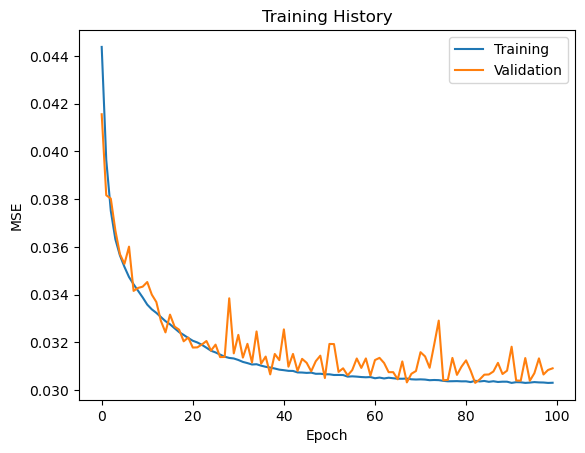

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training','Validation'])
plt.show()

32387/32387 [==============================] - 19s 581us/step


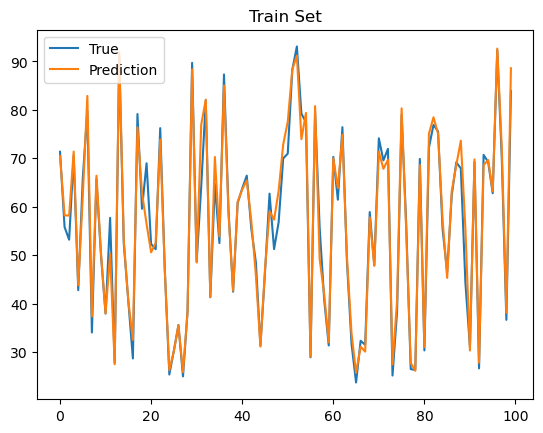

In [28]:
y_pred = enn.predict(X_train)
plt.plot(scaler2.inverse_transform(y_train[1100:1200]))
plt.plot(scaler2.inverse_transform(y_pred[1100:1200]))
plt.legend(['True','Prediction'])
plt.title('Train Set')
plt.show()

1106/1106 [==============================] - 1s 611us/step


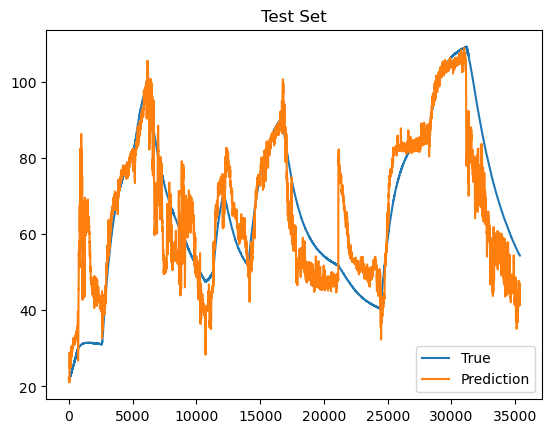

In [29]:
y_pred_test = enn.predict(X_test)
plt.plot(scaler2.inverse_transform(y_test))
plt.plot(scaler2.inverse_transform(y_pred_test))
plt.legend(['True','Prediction'])
plt.title('Test Set')
plt.show()

# RNN


In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_rnn,y_rnn, test_size = 0.2)

X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train_rnn = np.reshape(y_train, (y_train.shape[0],1))
X_val_rnn = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
y_val_rnn = np.reshape(y_val, (y_val.shape[0],1))

enn.trainable = False;

input_rnn = Input(shape=(X_train.shape[1], 1))
input_enn = Input(shape=(X_train.shape[1]))
rnn1 = SimpleRNN(16, return_sequences=True)(input_rnn)
drop1 = Dropout(0.2)(rnn1)
rnn2 = SimpleRNN(16, return_sequences=False)(drop1)
drop2 = Dropout(0.2)(rnn2)
enn_lay = enn(input_enn)
merge = concatenate(inputs = [enn_lay,drop2])
combine1 = Dense(16,activation = 'relu')(merge)
combine2 = Dense(16,activation = 'relu')(combine1)
final = Dense(1)(combine2)

ernn = Model(inputs=[input_rnn,input_enn], outputs=final)
ernn.compile(optimizer = "adam", loss = "mean_squared_error")
plot_model(ernn)
history = ernn.fit([X_train_rnn,X_train], y_train, epochs = 50, batch_size = 32,verbose=True,validation_data=([X_val_rnn,X_val], y_val))

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/50
16194/16194 [==============================] - 52s 3ms/step - loss: 0.0476 - val_loss: 0.0449
Epoch 2/50
16194/16194 [==============================] - 53s 3ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 3/50
16194/16194 [==============================] - 50s 3ms/step - loss: 0.0443 - val_loss: 0.0441
Epoch 4/50
16194/16194 [==============================] - 48s 3ms/step - loss: 0.0440 - val_loss: 0.0436
Epoch 5/50
16194/16194 [==============================] - 49s 3ms/step - loss: 0.0437 - val_loss: 0.0440
Epoch 6/50
16194/16194 [==============================] - 49s 3ms/step - loss: 0.0435 - val_loss: 0.0428
Epoch 7/50
16194/16194 [==============================] - 49s 3ms/step - loss: 0.0432 - val_loss: 0.0426
Epoch 8/50
16194/16194 [==============================] - 49s 3ms/step - loss: 0.0431 - val_loss: 0.0431
Epoch 9/50


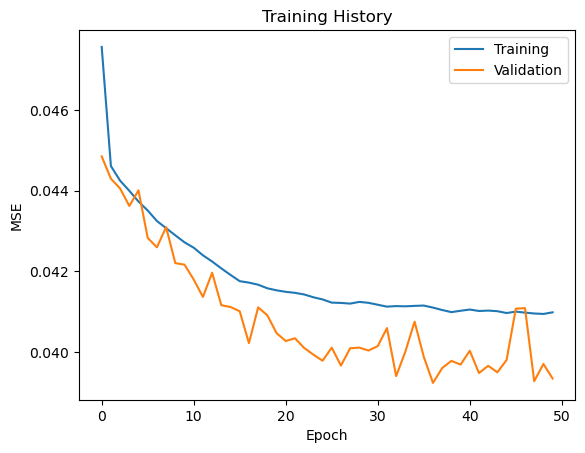

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Training','Validation'])
plt.show()

16194/16194 [==============================] - 20s 1ms/step


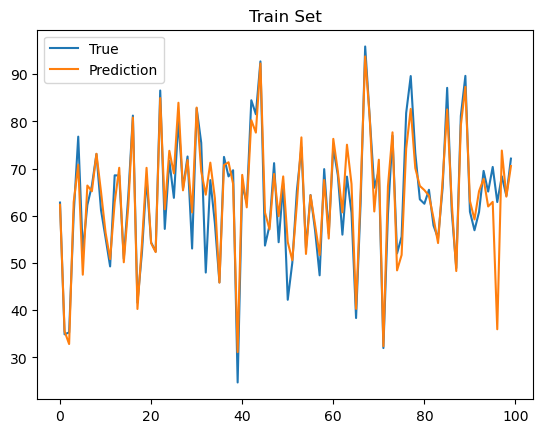

In [32]:
y_pred = ernn.predict([X_train_rnn,X_train])
plt.plot(scaler2.inverse_transform(y_train[1100:1200]))
plt.plot(scaler2.inverse_transform(y_pred[1100:1200]))
plt.legend(['True','Prediction'])
plt.title('Train Set')
plt.show()


1106/1106 [==============================] - 1s 1ms/step


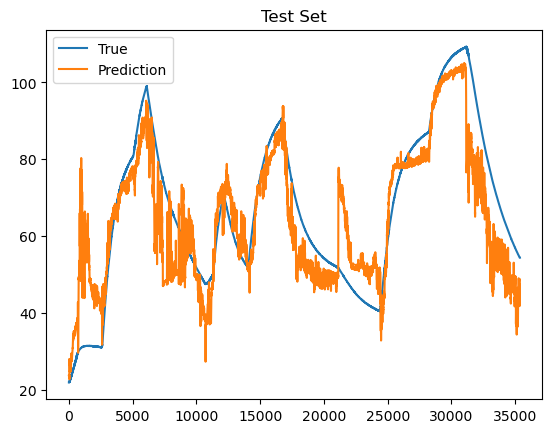

In [38]:
X_test_rnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

yr_pred_test = ernn.predict([X_test_rnn,X_test])
plt.plot(scaler2.inverse_transform(y_test))
plt.plot(scaler2.inverse_transform(yr_pred_test))
plt.legend(['True','Prediction'])
plt.title('Test Set')
plt.show()